In [1]:
import xarray as xr
import pathlib
import rasterio
import tqdm
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from dask.distributed import Client
import matplotlib.pyplot as plt

from data import KelpDataset
from data import Channel as Ch
import trafos

In [2]:
def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

# Write tif to nc

In [3]:
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [5]:
ds_tif_train = KelpDataset(img_dir="data_inpainted/train_satellite/", mask_dir="data/train_kelp/")
ds_tif_test = KelpDataset(img_dir="data_inpainted/test_satellite/", mask_dir=None)

In [6]:
ds = ds_tif_test

with ProcessPoolExecutor(max_workers=32) as p:
    res = list(tqdm.tqdm(
        p.map(ds.__getitem__, range(len(ds))),
        total=len(ds)
    ))

100%|██████████████████████████████████| 1426/1426 [00:24<00:00, 57.43it/s]


## Train

In [6]:
imgs, masks = zip(*res)
imgs = xr.DataArray(np.array(imgs), dims=["sample", "i", "j", "ch"], coords={"sample": ds.tile_ids})
masks = xr.DataArray(np.array(masks), dims=["sample", "i", "j"], coords={"sample": ds.tile_ids})

In [7]:
imgs.to_netcdf("data_ncf/train_imgs.ncf")
masks.to_netcdf("data_ncf/train_masks.ncf")

## Test

In [12]:
imgs, masks = zip(*res)
imgs = xr.DataArray(np.array(imgs), dims=["sample", "i", "j", "ch"], coords={"sample": ds.tile_ids})
imgs.to_netcdf("data_ncf/test_imgs.ncf")

# Load nc back

In [3]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 128,Total memory: 503.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35645,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 503.49 GiB
Comm: tcp://127.0.0.1:32955,Total threads: 16
Dashboard: http://127.0.0.1:45725/status,Memory: 62.94 GiB
Nanny: tcp://127.0.0.1:41837,


In [4]:
# For writing
# imgs = xr.open_dataarray("data_ncf/train_imgs.ncf", engine="netcdf4", chunks={"sample": 500, "i": None, "j": None, "ch": 1})
imgs = xr.open_dataarray("data_ncf/test_imgs.ncf", engine="netcdf4", chunks={"sample": 500, "i": None, "j": None, "ch": 1})

# For dev
# imgs = xr.open_dataarray("data_ncf/imgs.ncf", chunks={"sample": None, "i": None, "j": None, "ch": 1})
# imgs = imgs.isel(sample=np.random.choice(np.arange(imgs.sizes["sample"]), size=1000, replace=False))
imgs

<xarray.DataArray (sample: 1426, i: 350, j: 350, ch: 8)>
dask.array<open_dataset-__xarray_dataarray_variable__, shape=(1426, 350, 350, 8), dtype=float32, chunksize=(500, 350, 350, 1), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'AA408972' 'AA804258' ... 'ZY575159' 'ZY737533'
Dimensions without coordinates: i, j, ch

In [5]:
nir = imgs.isel(ch=Ch.NIR)
swir = imgs.isel(ch=Ch.SWIR)
r = imgs.isel(ch=Ch.R)
g = imgs.isel(ch=Ch.G)
b = imgs.isel(ch=Ch.B)

ndwi_1 = (g - nir) / (g + nir)
ndwi_2 = (nir - swir) / (nir + swir)
ndvi = (nir - r) / (nir + r)
gndvi = (nir - g) / (nir + g)
ndti = (r - g) / (r + g)
evi = 2.5 * (nir - r) / (nir + 6 * r - 7.5 * b + 1)
cari = ((nir - r) / (nir + r)) - ((nir - g) / (nir + g))

## For dev: cdf plots

In [43]:
def plot_cdf(x, vmin=0, vmax=1):
    x_q = x.quantile(q=ch_q["quantile"]).compute()

    fig, ax = plt.subplots()
    ax.plot(x_q, x_q["quantile"])
    ax.set_ylim(0, 1)
    ax.set_xlim(vmin, vmax)

    return x_q

<xarray.DataArray (quantile: 100)>
array([-0.5       ,  0.04321288,  0.04939269,  0.05114745,  0.05236816,
        0.05366515,  0.05717468,  0.05877685,  0.05984496,  0.06053161,
        0.06083678,  0.06129455,  0.06198119,  0.06297302,  0.06404113,
        0.06526183,  0.06594848,  0.06686401,  0.06724548,  0.06777953,
        0.06838989,  0.06869506,  0.06907653,  0.06961059,  0.07037353,
        0.07121276,  0.07220458,  0.0731964 ,  0.07403564,  0.07479858,
        0.0757904 ,  0.07640075,  0.07693481,  0.07762145,  0.07884216,
        0.07983398,  0.0808258 ,  0.08181762,  0.08288573,  0.08387756,
        0.0846405 ,  0.08616637,  0.08784484,  0.08898925,  0.09066772,
        0.0921936 ,  0.0934143 ,  0.09478759,  0.09669494,  0.09913635,
        0.10058593,  0.10241698,  0.10539245,  0.10806274,  0.10966491,
        0.1135559 ,  0.11676025,  0.12156677,  0.12797545,  0.13369749,
        0.14048766,  0.14971922,  0.15872191,  0.17031859,  0.18580626,
        0.20838927,  0.24050902,  0.28590393,  0.33572388,  0.38157654,
        0.41888428,  0.44978333,  0.47511292,  0.49563599,  0.51356506,
        0.52912903,  0.54316711,  0.55659485,  0.56941223,  0.58108521,
        0.592453  ,  0.60343933,  0.61419678,  0.62480164,  0.63517761,
        0.64562988,  0.65600586,  0.66638184,  0.6769104 ,  0.68782043,
        0.69880676,  0.71063232,  0.72337341,  0.73786926,  0.75480652,
        0.77662659,  0.80851746,  0.86421204,  0.99688721,  4.49992371])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

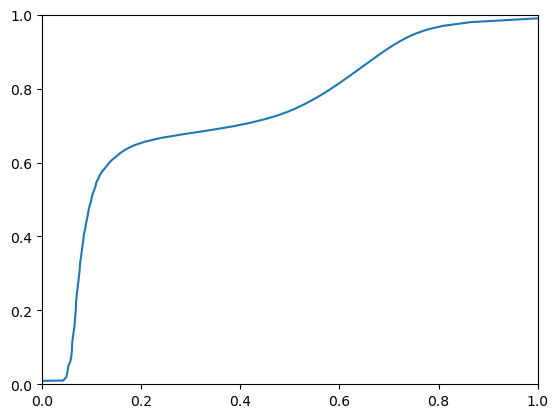

In [72]:
plot_cdf(normalize(swir, .1, .3))

<xarray.DataArray (quantile: 100)>
array([-0.40000001,  0.02333984,  0.0376831 ,  0.04024658,  0.04140624,
        0.04238281,  0.04354247,  0.04488525,  0.04659423,  0.04848632,
        0.05013427,  0.05184326,  0.05312499,  0.05458984,  0.05587158,
        0.0567871 ,  0.05794677,  0.05898437,  0.06020507,  0.0613037 ,
        0.06203613,  0.06325683,  0.06423339,  0.06502685,  0.06551513,
        0.06594238,  0.06704101,  0.06807861,  0.06936035,  0.07009277,
        0.07113037,  0.072229  ,  0.07308349,  0.07418212,  0.07534179,
        0.07650146,  0.07741699,  0.07851562,  0.08034667,  0.08193359,
        0.08309326,  0.08400878,  0.08553466,  0.08620605,  0.08742675,
        0.08876953,  0.09078369,  0.09230956,  0.09365234,  0.09511718,
        0.09761962,  0.09975585,  0.10189208,  0.10354003,  0.10781249,
        0.11110839,  0.11519775,  0.12020263,  0.12575683,  0.13106689,
        0.13729247,  0.14675292,  0.15432128,  0.16835937,  0.18276367,
        0.20644531,  0.24105224,  0.28731689,  0.33864745,  0.38668212,
        0.42739257,  0.45778808,  0.48006591,  0.49752197,  0.51192629,
        0.52413332,  0.53530276,  0.54549563,  0.55483401,  0.56405032,
        0.57241213,  0.58071291,  0.5891968 ,  0.59731448,  0.6060425 ,
        0.61434329,  0.62331545,  0.63240969,  0.64211428,  0.65224612,
        0.66372073,  0.67574465,  0.6897217 ,  0.70552981,  0.72457278,
        0.74813235,  0.78017581,  0.82888186,  0.93129885,  3.59993887])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

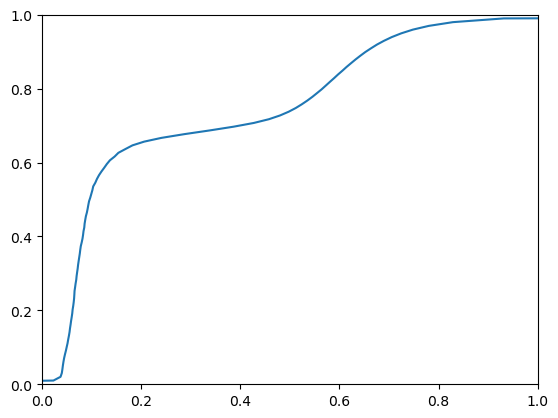

In [75]:
plot_cdf(normalize(nir, .1, .35))

<xarray.DataArray (quantile: 100)>
array([-1.        , -0.0185547 ,  0.07360838,  0.09436034,  0.10092162,
        0.10519408,  0.10809325,  0.11068724,  0.11312865,  0.11572264,
        0.11862181,  0.12319945,  0.12792967,  0.1326599 ,  0.13677977,
        0.13952635,  0.14440916,  0.14868163,  0.15097044,  0.15203856,
        0.15371703,  0.15722655,  0.16043089,  0.1628723 ,  0.16714476,
        0.16989134,  0.17111205,  0.17218016,  0.17324828,  0.17462157,
        0.17752074,  0.18164061,  0.18484496,  0.18698119,  0.18865965,
        0.19140624,  0.19293211,  0.19537352,  0.19873045,  0.20285033,
        0.20498656,  0.20742796,  0.20986937,  0.2120056 ,  0.21597289,
        0.21994017,  0.22360228,  0.22772215,  0.23046874,  0.23352049,
        0.23733519,  0.24374388,  0.24999999,  0.25366208,  0.25900266,
        0.26373288,  0.27090451,  0.27822873,  0.28875729,  0.29592893,
        0.30584714,  0.31591794,  0.32934567,  0.34078977,  0.3529968 ,
        0.36856076,  0.3793945 ,  0.39083859,  0.40258786,  0.4134216 ,
        0.42242429,  0.43295285,  0.44195554,  0.4512634 ,  0.45980832,
        0.46896359,  0.47705075,  0.4865112 ,  0.49490353,  0.5032959 ,
        0.51275635,  0.52114868,  0.52984619,  0.54006958,  0.55029297,
        0.56021118,  0.57043457,  0.58187866,  0.59362793,  0.6078186 ,
        0.62200928,  0.63803101,  0.65618896,  0.67816162,  0.70898438,
        0.75582886,  0.83898926,  1.01873779,  1.45910645,  8.99984741])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

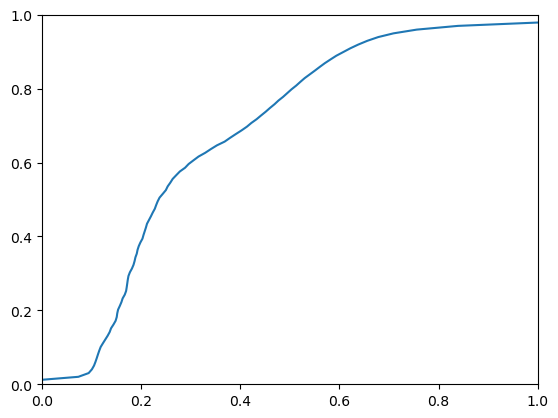

In [69]:
plot_cdf(normalize(r, .1, .2))

<xarray.DataArray (quantile: 100)>
array([-1.        , -0.13391115,  0.0935974 ,  0.12731932,  0.13662718,
        0.14181517,  0.14532469,  0.14837645,  0.15127562,  0.15478514,
        0.15814207,  0.16210936,  0.16500853,  0.16821288,  0.17233275,
        0.17645262,  0.17996214,  0.18316649,  0.18591307,  0.18835448,
        0.19033812,  0.19232176,  0.19476317,  0.1981201 ,  0.20086668,
        0.20300291,  0.20666502,  0.20971678,  0.21185301,  0.21429442,
        0.21658324,  0.21917723,  0.22222899,  0.22543333,  0.23016356,
        0.23382567,  0.23825072,  0.24130248,  0.24374388,  0.24649046,
        0.25122067,  0.25411984,  0.25732419,  0.26022336,  0.26312253,
        0.26510617,  0.26861569,  0.27380368,  0.27929685,  0.28372189,
        0.28601071,  0.28952023,  0.29394528,  0.3000488 ,  0.30569455,
        0.31027219,  0.31484982,  0.3214111 ,  0.32797238,  0.33605954,
        0.3441467 ,  0.35192868,  0.35986325,  0.36703488,  0.37603757,
        0.38626096,  0.39404294,  0.40090939,  0.4096069 ,  0.41708371,
        0.42318723,  0.4323425 ,  0.43997189,  0.44668576,  0.45416257,
        0.46194455,  0.46896359,  0.47567746,  0.48315427,  0.49063107,
        0.4978027 ,  0.50497437,  0.51397705,  0.52114868,  0.52786255,
        0.53671265,  0.5461731 ,  0.55426025,  0.56555176,  0.57775879,
        0.58920288,  0.60476685,  0.62033081,  0.64199829,  0.67114258,
        0.71798706,  0.80877686,  0.9883728 ,  1.41653442,  8.99984741])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

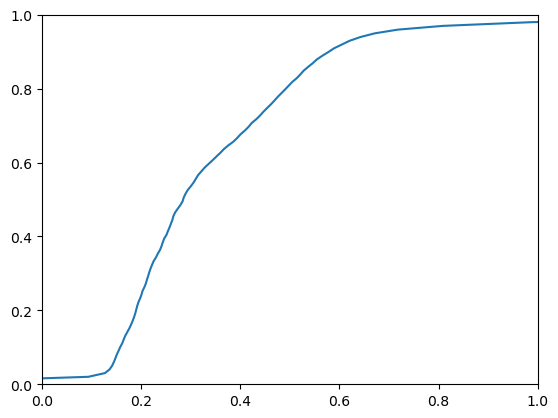

In [68]:
plot_cdf(normalize(g, .1, .2))

<xarray.DataArray (quantile: 100)>
array([-1.        , -0.42245483,  0.03012083,  0.09497069,  0.11816405,
        0.12701415,  0.13250731,  0.13723753,  0.14150999,  0.14578246,
        0.14990233,  0.15432738,  0.15890501,  0.1628723 ,  0.16744994,
        0.17141722,  0.17507933,  0.17935179,  0.18362425,  0.18743895,
        0.19125365,  0.19491576,  0.1981201 ,  0.20117186,  0.20422362,
        0.20727538,  0.21047972,  0.21353148,  0.21612547,  0.21887206,
        0.22161864,  0.22436522,  0.22772215,  0.2309265 ,  0.23367308,
        0.23611449,  0.23916624,  0.24206541,  0.24496458,  0.24832152,
        0.2509155 ,  0.25427243,  0.25671384,  0.2597656 ,  0.26235959,
        0.26525876,  0.26800534,  0.27075192,  0.27365109,  0.27670285,
        0.27975461,  0.28250119,  0.2849426 ,  0.28784177,  0.29089352,
        0.29394528,  0.29669186,  0.29959103,  0.3024902 ,  0.30554196,
        0.30828854,  0.31118771,  0.31408688,  0.31729123,  0.32049558,
        0.32385251,  0.32690427,  0.33010861,  0.33361813,  0.33712766,
        0.34063718,  0.34429929,  0.34765622,  0.35131833,  0.3554382 ,
        0.35955808,  0.36352536,  0.36795041,  0.37222287,  0.37664792,
        0.38122556,  0.38626096,  0.39190671,  0.39755246,  0.40350339,
        0.41036984,  0.4172363 ,  0.4247131 ,  0.43295285,  0.443634  ,
        0.45385739,  0.46789548,  0.48422238,  0.50558472,  0.53762817,
        0.59225464,  0.68334961,  0.86080933,  1.26165771,  8.99984741])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

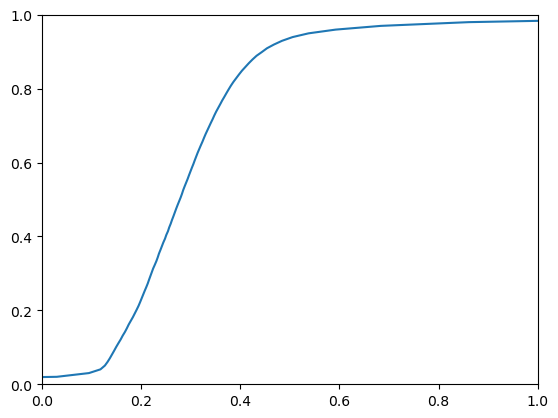

In [67]:
plot_cdf(normalize(b, .1, .2))

/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (quantile: 100)>
array([-1.20000005,  0.1133706 ,  0.16147685,  0.18874023,  0.20795697,
        0.22322851,  0.23581129,  0.24682015,  0.2567178 ,  0.26568896,
        0.27394396,  0.28175128,  0.28980678,  0.29671186,  0.30415326,
        0.31138659,  0.31837466,  0.32549134,  0.33275917,  0.34019747,
        0.3481155 ,  0.35623342,  0.3652038 ,  0.37538238,  0.38428986,
        0.39658451,  0.41289026,  0.4344317 ,  0.46270749,  0.49581072,
        0.53766281,  0.5794963 ,  0.62498713,  0.6705095 ,  0.70794171,
        0.73549062,  0.75573212,  0.76710004,  0.77580786,  0.78295684,
        0.78887129,  0.79406101,  0.79947549,  0.80282742,  0.8055892 ,
        0.80752856,  0.80955738,  0.81145447,  0.81350988,  0.81574285,
        0.81788065,  0.81962287,  0.8207891 ,  0.82171637,  0.82249749,
        0.82326651,  0.82407898,  0.82480353,  0.82554001,  0.82627738,
        0.82721424,  0.82821578,  0.82904381,  0.82993305,  0.83097804,
        0.83209288,  0.83329272,  0.83438987,  0.83562279,  0.83662421,
        0.83774465,  0.83879757,  0.83967471,  0.84066248,  0.84156436,
        0.84226036,  0.84303278,  0.84384489,  0.84465837,  0.84528637,
        0.84596461,  0.8469274 ,  0.8479324 ,  0.84938437,  0.85089231,
        0.85276908,  0.85502028,  0.85661525,  0.85797828,  0.85977179,
        0.86229807,  0.86448389,  0.86691171,  0.86995518,  0.87470597,
        0.88022923,  0.88677353,  0.8963753 ,  0.92786884,  2.79999995])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

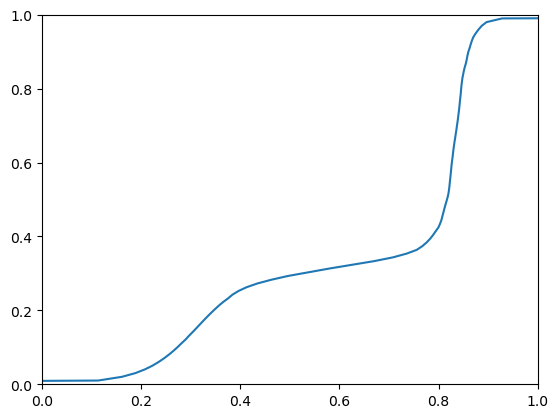

In [61]:
plot_cdf(normalize(ndwi_1, -.4, .1))

<xarray.DataArray (quantile: 100)>
array([-2.99999976,  0.10057305,  0.18032947,  0.21598639,  0.23689135,
        0.25206432,  0.26143077,  0.2694912 ,  0.2761448 ,  0.28138036,
        0.28628024,  0.29052934,  0.29459482,  0.29845098,  0.30125797,
        0.30420932,  0.30744666,  0.31041279,  0.3131313 ,  0.315745  ,
        0.31886554,  0.32147399,  0.32461077,  0.32857111,  0.33267066,
        0.3366037 ,  0.33956802,  0.34184227,  0.3441236 ,  0.34717554,
        0.34954888,  0.35215896,  0.35462856,  0.35742879,  0.35960054,
        0.36122823,  0.36288297,  0.3652567 ,  0.36739722,  0.36940405,
        0.37078649,  0.37229577,  0.37438217,  0.37584651,  0.37764463,
        0.37966928,  0.38176478,  0.38361138,  0.38537487,  0.38708267,
        0.38918319,  0.39130241,  0.3933562 ,  0.39507422,  0.39715791,
        0.39903867,  0.40127012,  0.4033674 ,  0.40590465,  0.40782002,
        0.41069604,  0.41305673,  0.41577554,  0.41799212,  0.42044577,
        0.42307693,  0.4268111 ,  0.42989531,  0.43346179,  0.43728316,
        0.44207293,  0.44677106,  0.45166555,  0.45755589,  0.46294171,
        0.46892363,  0.47621292,  0.48361743,  0.49134386,  0.49976864,
        0.50859064,  0.51811457,  0.52845299,  0.53961718,  0.5510757 ,
        0.5632776 ,  0.57623363,  0.58958088,  0.60400665,  0.61938906,
        0.63601014,  0.65392315,  0.67375273,  0.69586706,  0.72136253,
        0.75149947,  0.78909822,  0.84101415,  0.93072081,  3.66666651])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

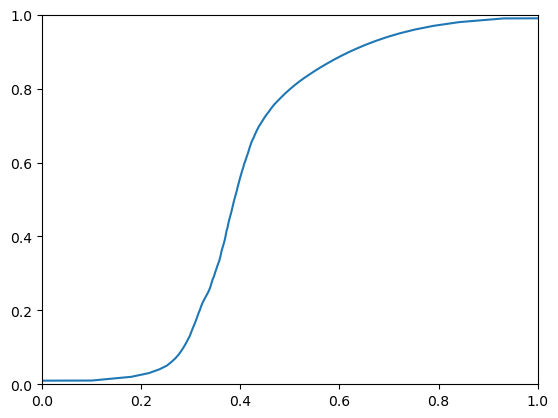

In [45]:
plot_cdf(normalize(ndwi_2, -.1, .2))

<xarray.DataArray (quantile: 100)>
array([-2.11111116,  0.04367739,  0.06162303,  0.06837334,  0.07325032,
        0.07835714,  0.08150394,  0.08442309,  0.08694667,  0.08847683,
        0.08999179,  0.09146067,  0.09322096,  0.09466761,  0.09557731,
        0.09664749,  0.0978607 ,  0.09888832,  0.09985146,  0.10064919,
        0.10153642,  0.10239765,  0.10317896,  0.10376791,  0.10445987,
        0.10529957,  0.10608879,  0.10694134,  0.10782866,  0.10870904,
        0.10946399,  0.11016359,  0.110964  ,  0.11171931,  0.1123812 ,
        0.1130488 ,  0.11374453,  0.11451648,  0.11537924,  0.1161567 ,
        0.11685895,  0.117598  ,  0.11854753,  0.11931226,  0.12012652,
        0.12104108,  0.12180826,  0.12261184,  0.12371565,  0.12474263,
        0.12619133,  0.12753786,  0.12927797,  0.13101569,  0.13292736,
        0.13487382,  0.13709486,  0.14001445,  0.14312261,  0.1470772 ,
        0.15246074,  0.16048057,  0.17007297,  0.17974581,  0.19591521,
        0.21915234,  0.24758455,  0.28174217,  0.31475738,  0.35964689,
        0.40421862,  0.44616237,  0.4807798 ,  0.50629782,  0.52576059,
        0.5415836 ,  0.55497015,  0.56675446,  0.57763124,  0.58776915,
        0.59724188,  0.60647011,  0.61541539,  0.62422091,  0.6330179 ,
        0.64171493,  0.65056974,  0.65968758,  0.66893464,  0.67867953,
        0.68902117,  0.70006692,  0.71220124,  0.72564465,  0.74099922,
        0.75934339,  0.78248852,  0.81462473,  0.8698369 ,  2.33333325])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

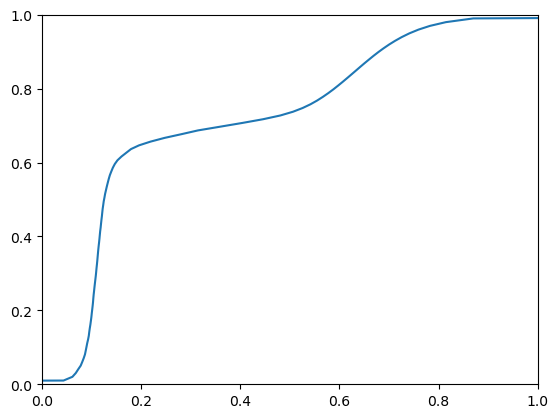

In [49]:
plot_cdf(normalize(ndvi, -.05, .4))

<xarray.DataArray (quantile: 100)>
array([-1.49999988,  0.06010929,  0.08635394,  0.09435538,  0.09980898,
        0.1044117 ,  0.1083707 ,  0.11090693,  0.1129301 ,  0.1147516 ,
        0.11685685,  0.11835145,  0.1194873 ,  0.12081642,  0.12269244,
        0.12425641,  0.12551303,  0.12672301,  0.12756051,  0.12836285,
        0.12892805,  0.12945135,  0.13012928,  0.13080601,  0.13144971,
        0.1320297 ,  0.13278128,  0.13360441,  0.13433538,  0.13521282,
        0.13614649,  0.136981  ,  0.13800846,  0.13892272,  0.1399226 ,
        0.14085165,  0.14172246,  0.14246348,  0.14315352,  0.14398813,
        0.14476885,  0.14538333,  0.14599705,  0.14660084,  0.14727791,
        0.14791876,  0.14856969,  0.14934243,  0.1503143 ,  0.15176614,
        0.15354764,  0.15540846,  0.15712127,  0.15870221,  0.16039287,
        0.162009  ,  0.16431049,  0.16710377,  0.17161585,  0.17594057,
        0.18086928,  0.18682678,  0.1940833 ,  0.20355655,  0.22042447,
        0.24338192,  0.27457542,  0.31251073,  0.35041975,  0.38528096,
        0.42015773,  0.44774377,  0.47130692,  0.48925811,  0.50284624,
        0.51309174,  0.52051467,  0.52899683,  0.53647214,  0.54323703,
        0.54983544,  0.55603403,  0.56209058,  0.56802112,  0.57384449,
        0.57987225,  0.5860734 ,  0.59182763,  0.5985406 ,  0.60504669,
        0.61192584,  0.61940181,  0.62764984,  0.63682389,  0.64730954,
        0.66003585,  0.6760498 ,  0.69876927,  0.73885781,  1.83333325])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

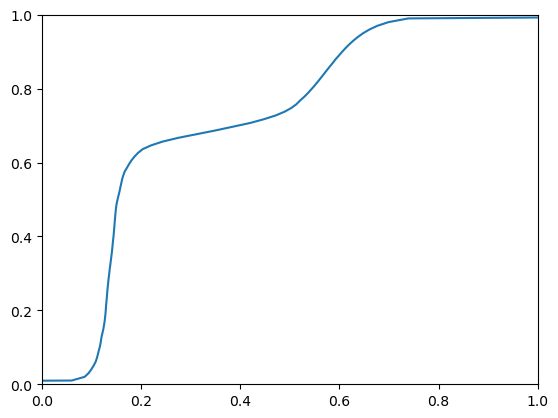

In [50]:
plot_cdf(normalize(gndvi, -.1, .5))

/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (quantile: 100)>
array([-6.16666651,  0.14547162,  0.21669421,  0.24480769,  0.26497871,
        0.27801263,  0.28505439,  0.29240415,  0.29941583,  0.30587518,
        0.31259051,  0.31730121,  0.32300189,  0.32800931,  0.33197835,
        0.33609259,  0.33965725,  0.34368607,  0.34737694,  0.35079154,
        0.35442495,  0.35773614,  0.36066741,  0.36321142,  0.36600316,
        0.36894795,  0.37152389,  0.37394202,  0.37633502,  0.37885314,
        0.38117778,  0.38320041,  0.38497517,  0.38681847,  0.38877541,
        0.3906717 ,  0.39288384,  0.39476776,  0.39688411,  0.39902914,
        0.40121859,  0.40350431,  0.40574929,  0.40828162,  0.41065511,
        0.41337863,  0.4159075 ,  0.41822132,  0.42062992,  0.42323667,
        0.42548952,  0.42846191,  0.43157187,  0.43489504,  0.43811408,
        0.4414731 ,  0.44424352,  0.44700581,  0.45017564,  0.45344505,
        0.45768687,  0.46134245,  0.4650777 ,  0.46966937,  0.47488225,
        0.47918874,  0.48451462,  0.4895145 ,  0.4939397 ,  0.49843687,
        0.50291628,  0.5075624 ,  0.5119735 ,  0.51679695,  0.52129072,
        0.52589834,  0.53070706,  0.53576291,  0.54095095,  0.54584438,
        0.55048543,  0.55529028,  0.56006008,  0.5655852 ,  0.57082778,
        0.57649255,  0.58263892,  0.5890817 ,  0.59541911,  0.60226059,
        0.60988021,  0.61824262,  0.62736613,  0.63813293,  0.65006632,
        0.66687936,  0.68786865,  0.72561103,  0.86622912,  7.16666651])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

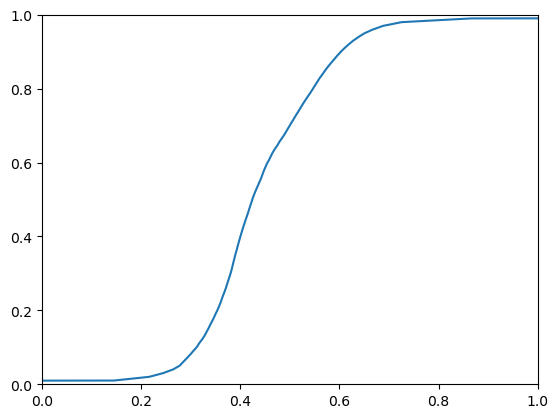

In [55]:
plot_cdf(normalize(ndti, -.075, .075))

<xarray.DataArray (quantile: 100)>
array([-8.83897852e+03,  1.11517962e-01,  1.25051975e-01,  1.29665300e-01,
        1.32993057e-01,  1.35975197e-01,  1.38837963e-01,  1.40663132e-01,
        1.42135993e-01,  1.43410482e-01,  1.44394860e-01,  1.45248979e-01,
        1.46306008e-01,  1.47290200e-01,  1.48062304e-01,  1.48664877e-01,
        1.49430886e-01,  1.50130227e-01,  1.50783867e-01,  1.51303902e-01,
        1.51798591e-01,  1.52413055e-01,  1.52867809e-01,  1.53316185e-01,
        1.53746113e-01,  1.54197797e-01,  1.54752403e-01,  1.55279905e-01,
        1.55805483e-01,  1.56371087e-01,  1.56829089e-01,  1.57267660e-01,
        1.57722458e-01,  1.58247709e-01,  1.58622816e-01,  1.59047216e-01,
        1.59472600e-01,  1.59925699e-01,  1.60452619e-01,  1.60963491e-01,
        1.61392018e-01,  1.61819920e-01,  1.62407249e-01,  1.62906915e-01,
        1.63456127e-01,  1.64001867e-01,  1.64467394e-01,  1.65034220e-01,
        1.65599585e-01,  1.66320324e-01,  1.67321742e-01,  1.68224275e-01,
        1.69407204e-01,  1.70670658e-01,  1.71827912e-01,  1.73270434e-01,
        1.74773619e-01,  1.76538944e-01,  1.78637877e-01,  1.81382030e-01,
        1.85060471e-01,  1.89862655e-01,  1.95367086e-01,  2.01579019e-01,
        2.10343137e-01,  2.21743626e-01,  2.42233932e-01,  2.72734314e-01,
        3.09649527e-01,  3.50377446e-01,  3.91900539e-01,  4.28419679e-01,
        4.57151413e-01,  4.78653163e-01,  4.95392799e-01,  5.09027541e-01,
        5.20688951e-01,  5.31023324e-01,  5.40550649e-01,  5.49534261e-01,
        5.58046281e-01,  5.66360831e-01,  5.74566722e-01,  5.82742691e-01,
        5.90949064e-01,  5.99282384e-01,  6.07765496e-01,  6.16480291e-01,
        6.25550568e-01,  6.35139227e-01,  6.45365715e-01,  6.56439006e-01,
        6.68724179e-01,  6.82651401e-01,  6.98924303e-01,  7.18629003e-01,
        7.43751407e-01,  7.78762579e-01,  8.39210722e-01,  1.14982617e+05])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

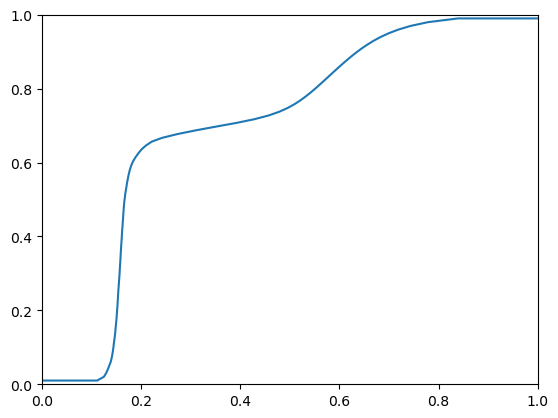

In [58]:
plot_cdf(normalize(evi, -.075, .4))

/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (quantile: 100)>
array([-12.75136662,   0.0646489 ,   0.23035194,   0.27529743,
         0.30141211,   0.32108137,   0.33586732,   0.348674  ,
         0.35938571,   0.36941653,   0.3780736 ,   0.3867313 ,
         0.39428034,   0.40195209,   0.40905151,   0.41598377,
         0.42228746,   0.42845431,   0.43414518,   0.43984053,
         0.44545454,   0.45132187,   0.45756522,   0.46351761,
         0.46905825,   0.4745658 ,   0.47995792,   0.48563606,
         0.49097127,   0.49650767,   0.50187504,   0.50730443,
         0.51258808,   0.51852155,   0.52520758,   0.53066469,
         0.53685063,   0.54259914,   0.54726106,   0.55197948,
         0.55710042,   0.56124151,   0.56536233,   0.56898379,
         0.57244724,   0.57619268,   0.58069032,   0.58472669,
         0.58870155,   0.59224296,   0.59525079,   0.59847248,
         0.60162032,   0.60451108,   0.60773504,   0.6111567 ,
         0.61407101,   0.61724085,   0.62016585,   0.62297648,
         0.62574303,   0.6284067 ,   0.63117212,   0.63348222,
         0.63628036,   0.6386342 ,   0.64110023,   0.64348638,
         0.64573658,   0.64827019,   0.65102577,   0.65432119,
         0.65717947,   0.66027743,   0.66349608,   0.66706932,
         0.67067569,   0.6738894 ,   0.67749435,   0.68153167,
         0.68607754,   0.69047946,   0.69507819,   0.70007718,
         0.70457321,   0.70963895,   0.71459287,   0.72090816,
         0.72806151,   0.73389465,   0.74216104,   0.75025886,
         0.75919396,   0.76831806,   0.77709198,   0.79327101,
         0.81823272,   0.85352802,   0.94140428,  17.08148766])
Coordinates:
  * quantile  (quantile) float64 0.0 0.0101 0.0202 0.0303 ... 0.9798 0.9899 1.0

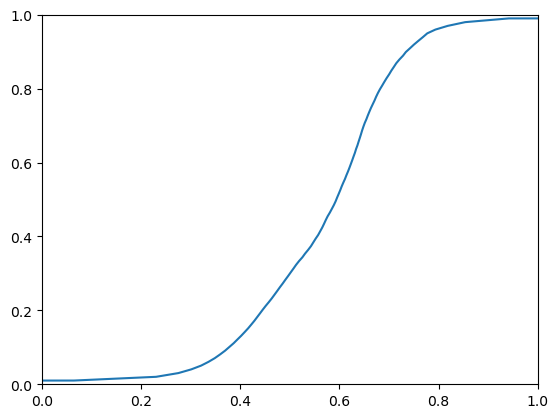

In [60]:
plot_cdf(normalize(cari, -.06, .06))

## For prod: normalize

In [6]:
# Now normalize
nir = normalize(nir, .1, .35)
swir = normalize(swir, .1, .3)
r = normalize(r, .1, .2)
g = normalize(g, .1, .2)
b = normalize(b, .1, .2)

ndwi_1 = normalize(ndwi_1, -.4, .1)
ndwi_2 = normalize(ndwi_2, -.1, .2)
ndvi = normalize(ndvi, -.05, .4)
gndvi = normalize(gndvi, -.1, .5)
ndti = normalize(ndti, -.075, .075)
evi = normalize(evi, -.075, .4)
cari = normalize(cari, -.06, .06)

In [7]:
# Stick to Channel order
imgs_fe = xr.concat([
    swir, 
    nir, 
    r, 
    g, 
    b,
    imgs.isel(ch=Ch.IS_CLOUD),
    imgs.isel(ch=Ch.IS_LAND),
    imgs.isel(ch=Ch.NOT_CLOUD_LAND),
    ndwi_1,
    ndwi_2, 
    ndvi,
    gndvi, 
    ndti,
    evi,
    cari 
], dim="ch")

imgs_fe = imgs_fe.assign_coords({"ch": [
    "swir",
    "nir",
    "r",
    "g",
    "b",
    "is_cloud",
    "is_land",
    "not_cloud_land",
    "ndwi_1",
    "ndwi_2",
    "ndvi",
    "gndvi",
    "ndti",
    "evi",
    "cari",
]})

imgs_fe = imgs_fe.transpose("sample", "i", "j", "ch")
imgs_fe = imgs_fe.clip(0, 1)
imgs_fe

<xarray.DataArray (sample: 1426, i: 350, j: 350, ch: 15)>
dask.array<clip, shape=(1426, 350, 350, 15), dtype=float32, chunksize=(500, 350, 350, 1), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'AA408972' 'AA804258' ... 'ZY575159' 'ZY737533'
  * ch       (ch) <U14 'swir' 'nir' 'r' 'g' 'b' ... 'gndvi' 'ndti' 'evi' 'cari'
Dimensions without coordinates: i, j

In [8]:
imgs_fe = imgs_fe.compute()
imgs_fe = imgs_fe.interpolate_na(dim="i", fill_value="extrapolate")
imgs_fe

/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/max/mambaforge/envs/keras3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (sample: 1426, i: 350, j: 350, ch: 15)>
array([[[[0.09028625, 0.06240234, 0.15203856, ..., 0.38757947,
          0.16013753, 0.6405293 ],
         [0.09120177, 0.06197509, 0.15325926, ..., 0.39794368,
          0.15884206, 0.6275717 ],
         [0.08654784, 0.05794677, 0.1351013 , ..., 0.3772844 ,
          0.16344172, 0.65340376],
         ...,
         [0.07624816, 0.05458984, 0.1338806 , ..., 0.43646562,
          0.15934819, 0.5794188 ],
         [0.07632446, 0.05275878, 0.12716673, ..., 0.42460236,
          0.16055721, 0.59424883],
         [0.07373046, 0.05446777, 0.12869261, ..., 0.42602497,
          0.16208993, 0.5924712 ]],

        [[0.08937072, 0.06087646, 0.15173338, ..., 0.39395916,
          0.15815346, 0.63255143],
         [0.08738708, 0.05892333, 0.14242552, ..., 0.3866496 ,
          0.16065645, 0.6416925 ],
         [0.08479308, 0.0578247 , 0.13739012, ..., 0.38442862,
          0.1619624 , 0.64447063],
...
         [0.45993042, 0.55837405, 0.41189572, ..., 0.40308324,
          0.634068  , 0.6134818 ],
         [0.42697144, 0.5194336 , 0.45599362, ..., 0.505594  ,
          0.5594471 , 0.4933609 ],
         [0.39401245, 0.46083984, 0.41189572, ..., 0.53731275,
          0.52429086, 0.45542267]],

        [[0.3784485 , 0.4817749 , 0.45797727, ..., 0.5038396 ,
          0.51045114, 0.49540037],
         [0.3784485 , 0.44259033, 0.45797727, ..., 0.6377984 ,
          0.4793217 , 0.33407742],
         [0.3618927 , 0.42299804, 0.41372678, ..., 0.535082  ,
          0.48671547, 0.4576971 ],
         ...,
         [0.47633362, 0.5194336 , 0.41189572, ..., 0.40308324,
          0.6086868 , 0.6146261 ],
         [0.45993042, 0.46083984, 0.41189572, ..., 0.40308324,
          0.5396154 , 0.61627144],
         [0.45993042, 0.42177734, 0.41189572, ..., 0.40308324,
          0.4725425 , 0.6172994 ]]]], dtype=float32)
Coordinates:
  * sample   (sample) object 'AA408972' 'AA804258' ... 'ZY575159' 'ZY737533'
  * ch       (ch) <U14 'swir' 'nir' 'r' 'g' 'b' ... 'gndvi' 'ndti' 'evi' 'cari'
Dimensions without coordinates: i, j

In [9]:
np.where(imgs_fe.isnull())

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [10]:
import matplotlib.pyplot as plt

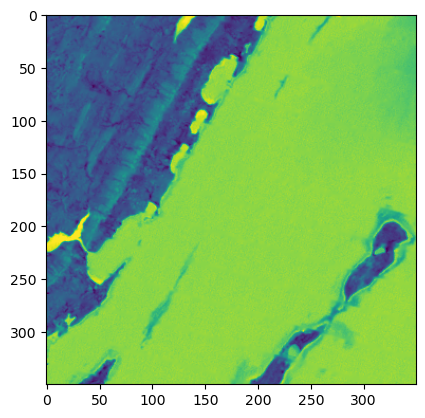

In [11]:
plt.imshow(imgs_fe[7, :, :, 8])

In [12]:
# imgs_fe.to_netcdf("data_ncf/train_imgs_fe.nc", engine="netcdf4")
imgs_fe.to_netcdf("data_ncf/test_imgs_fe.nc", engine="netcdf4")